In [187]:
import numpy as np
from geo_modules import *
from wait_time import *

In [188]:
model_config = {
    "time_baseline": {
        "morning": 7.0,
        "lunch": 10.0,
        "afternoon": 5.0,
        "evening": 3.0,
        "night": 1.0,
    },
    "PEAK_TIMES": {
        "lunch": 12,
        "evening": 18,
    },
}


# 1. S-curve
def s_curve(sf, a=1.0, b=20.0, c=3.65, d=57.08):
    return a + (b - a) * (sf**c) / (d + sf**c)


# 2. Score Factor
def compute_score_factor(info, hour, config):
    time_slot = get_time_slot(hour)
    time_baseline = config["time_baseline"].get(time_slot, 5.0)
    rating = max(info.get("rating", 4.0), 1.0)
    density = info.get("density", 0.5)

    sf = 3.0 * density + 1.0 * (time_baseline / 10.0) + 1.2 * ((5.0 - rating) / 4.0)
    return sf, rating, density


def proximity_weight(hour, peak_hours):
    min_diff = min(abs(hour - ph) for ph in peak_hours)
    return np.exp(-0.3 * min_diff)


def compute_score_factor_v1(info, hour, config):
    time_slot = get_time_slot(hour)
    time_baseline = config["time_baseline"].get(time_slot, 5.0)
    peak_hours = list(config["PEAK_TIMES"].values())

    rating = max(info.get("rating", 4.0), 1.0)
    density = info.get("density", 0.5)
    adjusted_density = (density - 0.9) * 10

    proximity = proximity_weight(hour, peak_hours)

    stretched_density = max((density - 0.95) * 100, 0)

    sf = (
        5.0 * adjusted_density
        + 2.0 * proximity
        + -0.5 * rating
        + 3 * (time_baseline / 10.0)
    )

    return sf, rating, density, proximity


def compute_score_factor_v2(info, hour, config):
    time_slot = get_time_slot(hour)
    time_baseline = config["time_baseline"].get(time_slot, 5.0)
    peak_hours = list(config["PEAK_TIMES"].values())

    rating = max(info.get("rating", 4.0), 1.0)
    density = info.get("density", 0.5)
    proximity = proximity_weight(hour, peak_hours)

    stretched_density = np.exp(10 * max(density - 0.95, 0))  # exponential
    curved_proximity = np.log1p(5 * proximity)  # log scale
    inverse_rating = (5.0 - rating) / 4.0  # 그대로 유지

    score = (
        2.0 * stretched_density
        + 3.0 * curved_proximity
        + 1.5 * inverse_rating
        + 2.0 * (time_baseline / 10.0)
    )
    return score, rating, density, proximity


def compute_score_factor_final(info, hour, config):
    time_slot = get_time_slot(hour)
    time_baseline = config["time_baseline"].get(time_slot, 5.0)
    peak_hours = list(config["PEAK_TIMES"].values())

    rating = max(info.get("rating", 4.0), 1.0)
    density = info.get("density", 0.5)
    proximity = proximity_weight(hour, peak_hours)

    stretched_density = (density - 0.9) * 10
    stretched_density = max(0.0, min(stretched_density, 1.0))
    curved_proximity = 1.0 / (1.0 + np.exp(-5 * (proximity - 0.5)))
    inverse_rating = 1.0 / rating

    score = (
        2.0 * stretched_density
        + 3.0 * curved_proximity
        + 1.5 * inverse_rating
        + 2.0 * (time_baseline / 10.0)
    )

    return score, rating, density, proximity


def logistic_sigmoid(x, L=9.11, k=5.00, x0=7.17, offset=4.69):
    return L / (1 + np.exp(-k * (x - x0))) + offset


def predict_wait_time(score, L=9.6, k=5.00, x0=7.12, offset=4.69):
    return logistic_sigmoid(score, L=9.11, k=5.00, x0=7.17, offset=4.69)


# 3. Wait Time
def estimate_wait_timev2(lat, lon, hour=None, config=model_config):
    info = fetch_foursquare_info(lat, lon)
    hour = hour or int(np.datetime64("now", "h").astype(int) % 24)

    # sf, rating, density, review_count = compute_score_factor(info, hour, config)
    sf, rating, density, proximity = compute_score_factor_final(info, hour, config)
    wait_time = round(predict_wait_time(sf), 2)

    return wait_time, sf

In [189]:
"""# Simulate data for coffe shops
from geo_modules import find_nearby_cafes


areas = {
    "UCLA": (34.0689, -118.4452),
    "Veteran Ave": (34.0588, -118.4473),
}


radius = 1000
limit = 20


cafes_by_area = {}


for area_name, (lat, lon) in areas.items():
    print(f"\n📍 Finding cafes near {area_name}...")
    cafes = find_nearby_cafes(lat, lon, radius_m=radius, limit=limit)
    cafes_by_area[area_name] = cafes

    for cafe in cafes:
        print(f"☕ {cafe['name']} — ({cafe['lat']:.5f}, {cafe['lon']:.5f})")"""

'# Simulate data for coffe shops\nfrom geo_modules import find_nearby_cafes\n\n\nareas = {\n    "UCLA": (34.0689, -118.4452),\n    "Veteran Ave": (34.0588, -118.4473),\n}\n\n\nradius = 1000\nlimit = 20\n\n\ncafes_by_area = {}\n\n\nfor area_name, (lat, lon) in areas.items():\n    print(f"\n📍 Finding cafes near {area_name}...")\n    cafes = find_nearby_cafes(lat, lon, radius_m=radius, limit=limit)\n    cafes_by_area[area_name] = cafes\n\n    for cafe in cafes:\n        print(f"☕ {cafe[\'name\']} — ({cafe[\'lat\']:.5f}, {cafe[\'lon\']:.5f})")'

### Simulate based on tuned & researched data

In [190]:
import pandas as pd

df = pd.read_csv("sigmoid_based_wait_time.csv")

In [191]:
df.columns = [i.strip() for i in df.columns]

In [192]:
df_long = df.melt(
    id_vars=["name", "lat", "lon"],
    value_vars=["morning", "lunch", "afternoon", "evening", "night"],
    var_name="time_slot",
    value_name="hypothetical_wait",
)

In [193]:
df_long["hypothetical_wait"] = df_long["hypothetical_wait"].replace(" ", pd.NA)

df_long = df_long.dropna(subset=["hypothetical_wait"]).reset_index(drop=True)

In [194]:
slot_to_hour = {
    "morning": 9,
    "lunch": 12,
    "afternoon": 15,
    "evening": 18,
    "night": 22,
}

df_long["hour"] = df_long["time_slot"].map(slot_to_hour)

In [195]:
# Get simulation data est_time

from tqdm import tqdm

sf_list = []
rating_list = []
density_list = []
proximity_list = []


for _, row in tqdm(df_long.iterrows(), total=len(df_long)):
    lat, lon, hour = row["lat"], row["lon"], int(row["hour"])

    # get score factor only
    info = fetch_foursquare_info(lat, lon)
    sf, rating, density, proximity = compute_score_factor_final(
        info, hour, model_config
    )

    sf_list.append(sf)
    rating_list.append(rating)
    density_list.append(density)
    proximity_list.append(proximity)


df_long["score_factor"] = sf_list
df_long["rating"] = rating_list
df_long["density"] = density_list
df_long["proximity"] = proximity_list

100%|██████████| 27/27 [00:11<00:00,  2.41it/s]


In [196]:
df_long.to_csv("df_long.csv", index=False)

In [197]:
df_long.sort_values(by=["score_factor"], ascending=[False], inplace=True)

In [198]:
df_long.sort_values(
    by=["hypothetical_wait", "time_slot"], ascending=[True, False], inplace=True
)

In [199]:
df_long.sort_values(by=["density"], ascending=[False])

,name,lat,lon,time_slot,hypothetical_wait,hour,score_factor,rating,density,proximity
26,Just Boba Tea House,34.062500,-118.445000,night,7.7,22,3.162561,8.3,0.998574,0.301194
23,Just Boba Tea House,34.062500,-118.445000,evening,15.0,18,5.524635,8.3,0.998574,1.000000
10,Just Boba Tea House,34.062500,-118.445000,lunch,15.0,12,6.924635,8.3,0.998574,1.000000
17,Just Boba Tea House,34.062500,-118.445000,afternoon,9.7,15,4.308082,8.3,0.998574,0.406570
0,Anderson Cafe,34.069000,-118.445000,morning,8.5,9,4.605966,7.9,0.993011,0.406570
20,Anderson Cafe,34.069000,-118.445000,evening,15.0,18,5.422520,7.9,0.993011,1.000000
6,Anderson Cafe,34.069000,-118.445000,lunch,15.0,12,6.822520,7.9,0.993011,1.000000
13,Anderson Cafe,34.069000,-118.445000,afternoon,8.5,15,4.205966,7.9,0.993011,0.406570
9,Espresso Profeta,34.060268,-118.444206,lunch,15.0,12,6.646839,8.3,0.984685,1.000000
3,Espresso Profeta,34.060268,-118.444206,morning,5.7,9,4.430286,8.3,0.984685,0.406570


In [200]:
# drop if starbucks in name
df_long = df_long[~df_long["name"].str.contains("Starbucks", case=False, na=False)]
df_long

,name,lat,lon,time_slot,hypothetical_wait,hour,score_factor,rating,density,proximity
4,Kerckhoff Coffee House,34.070548,-118.443600,morning,2.0,9,3.798017,7.6,0.952239,0.406570
1,Cafe Elysee,34.060277,-118.446952,morning,2.0,9,3.616758,7.8,0.943429,0.406570
18,Kerckhoff Coffee House,34.070548,-118.443600,afternoon,2.0,15,3.398017,7.6,0.952239,0.406570
14,Cafe Elysee,34.060277,-118.446952,afternoon,2.0,15,3.216758,7.8,0.943429,0.406570
2,Coffee Bean & Tea Leaf,34.059700,-118.447300,morning,2.1,9,4.082664,5.0,0.961340,0.406570
15,Coffee Bean & Tea Leaf,34.059700,-118.447300,afternoon,2.1,15,3.682664,5.0,0.961340,0.406570
5,Ministry of Coffee,34.058100,-118.441700,morning,4.8,9,4.382823,8.0,0.981973,0.406570
19,Ministry of Coffee,34.058100,-118.441700,afternoon,4.8,15,3.982823,8.0,0.981973,0.406570
7,Cafe Elysee,34.060277,-118.446952,lunch,5.4,12,5.833312,7.8,0.943429,1.000000
21,Cafe Elysee,34.060277,-118.446952,evening,5.4,18,4.433312,7.8,0.943429,1.000000


In [201]:
%matplotlib inline

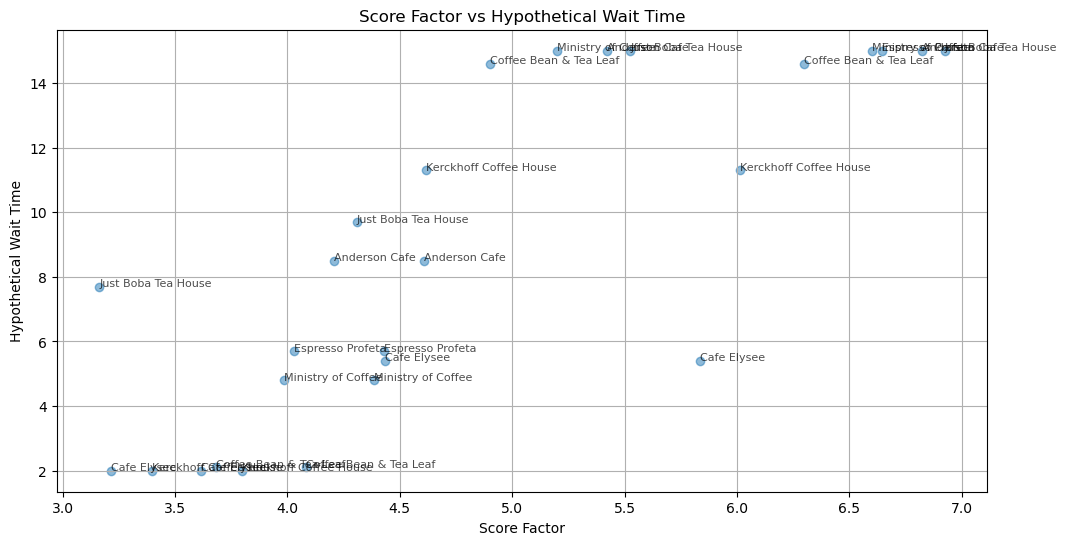

In [202]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.scatter(df_long["score_factor"], df_long["hypothetical_wait"], alpha=0.5)
plt.xlabel("Score Factor")
plt.ylabel("Hypothetical Wait Time")
plt.title("Score Factor vs Hypothetical Wait Time")
# label names on each point
for i, row in df_long.iterrows():
    plt.annotate(
        row["name"],
        (row["score_factor"], row["hypothetical_wait"]),
        fontsize=8,
        alpha=0.7,
    )
plt.grid()
plt.show()

In [203]:
df_binned = df_long.copy()
df_binned["sf_bin"] = pd.cut(df_binned["score_factor"], bins=10)

grouped = (
    df_binned.groupby("sf_bin")
    .agg({"score_factor": "mean", "hypothetical_wait": "mean"})
    .dropna()
)

/var/folders/lk/b7zqk0ps4792145cxptl4zwc0000gn/T/ipykernel_97349/477866394.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_binned.groupby("sf_bin")


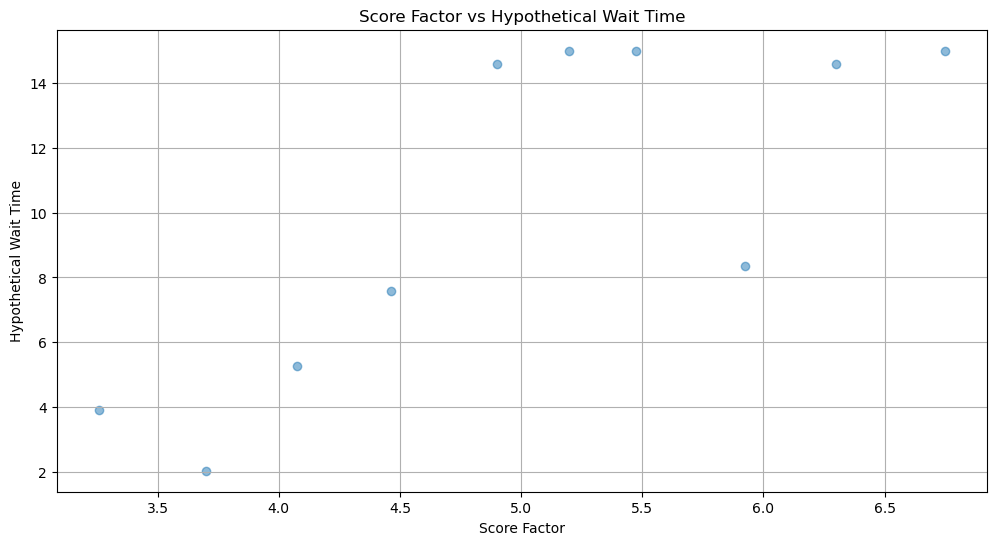

In [204]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.scatter(grouped["score_factor"], grouped["hypothetical_wait"], alpha=0.5)
plt.xlabel("Score Factor")
plt.ylabel("Hypothetical Wait Time")
plt.title("Score Factor vs Hypothetical Wait Time")

plt.grid()
plt.show()

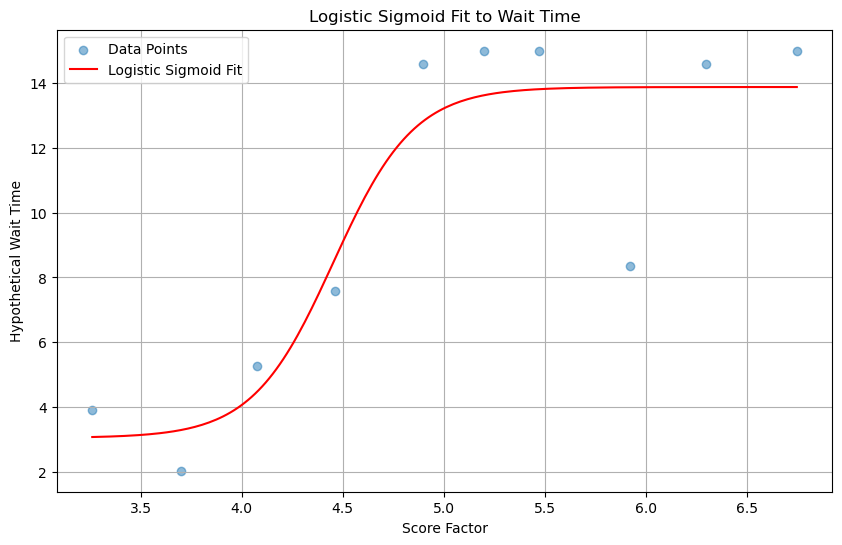

In [205]:
from scipy.optimize import curve_fit


def s_curve(sf, a, b, c, d):
    return a + (b - a) * (sf**c) / (d + sf**c)


def logistic_sigmoid(x, L, k, x0, offset):
    return L / (1 + np.exp(-k * (x - x0))) + offset


X = grouped["score_factor"].values
y = grouped["hypothetical_wait"].values

initial_guess = [13.0, 1.2, np.median(X), 2.0]  # L, k, x0, offset
param_bounds = (
    [5.0, 0.1, min(X), 0.0],
    [20.0, 5.0, max(X), 5.0],
)

popt, _ = curve_fit(
    logistic_sigmoid, X, y, p0=initial_guess, bounds=param_bounds, maxfev=20000
)

x_range = np.linspace(min(X), max(X), 200)
y_fit = logistic_sigmoid(x_range, *popt)

# 플롯
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.5, label="Data Points")
plt.plot(x_range, y_fit, color="red", label="Logistic Sigmoid Fit")
plt.xlabel("Score Factor")
plt.ylabel("Hypothetical Wait Time")
plt.title("Logistic Sigmoid Fit to Wait Time")
plt.legend()
plt.grid()
plt.show()

In [206]:
L, k, x0, offset = popt
print(f"Fitted Parameters: L={L:.2f}, k={k:.2f}, x0={x0:.2f}, offset={offset:.2f}")

Fitted Parameters: L=10.83, k=5.00, x0=4.45, offset=3.05


In [207]:
# get r squared
from sklearn.metrics import r2_score

y_pred = logistic_sigmoid(X, *popt)
r_squared = r2_score(y, y_pred)
print(f"R-squared: {r_squared:.4f}")

R-squared: 0.8285


In [211]:
def predict_wait_time(score):
    return logistic_sigmoid(score, *popt)


def logistic_sigmoid(x, L=10.83, k=5.00, x0=4.45, offset=3.05):
    return L / (1 + np.exp(-k * (x - x0))) + offset

In [212]:
estimate_wait_timev2(34.070548, -118.4436, hour=12, config=model_config)

(13.87, 6.014570611836913)

In [213]:
estimate_wait_timev2(34.069, -118.445, hour=13, config=model_config)

(13.88, 6.357849943729913)